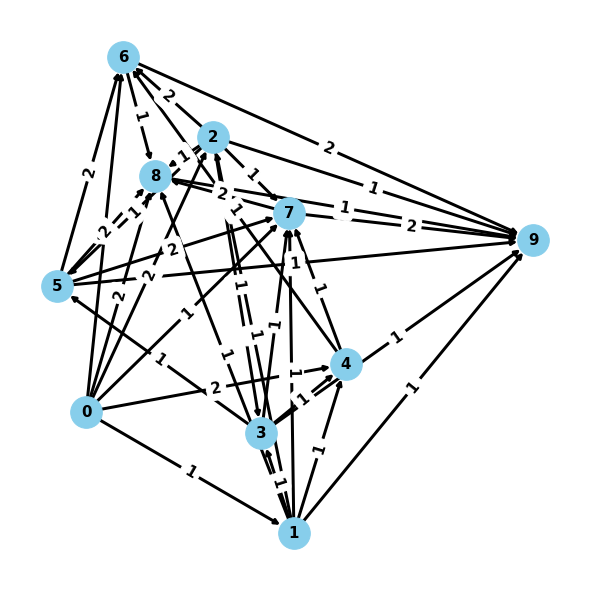

In [22]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from pyvis.network import Network

from DAG import DAG

dag = DAG(n = 10, roots = 1, strength=3,precalculate_paths = True)
dag.plot()

In [23]:
# dag.precalculate_paths = False
sim = dag.get_simulated_var(100000)
ana = dag.get_analytical_var()
for i in range(dag.size):
    print("simulated", i, ":",round(sim[i]), "| analytical", ":", round(ana[i]))

print("")
varsort = dag.get_varsortability(analytical = True, simulated = True, N = 100000)
print("varsortability:", varsort)

simulated 0 : 1 | analytical : 1
simulated 1 : 2 | analytical : 2
simulated 2 : 11 | analytical : 11
simulated 3 : 22 | analytical : 22
simulated 4 : 61 | analytical : 61
simulated 5 : 64 | analytical : 64
simulated 6 : 1022 | analytical : 1026
simulated 7 : 1137 | analytical : 1140
simulated 8 : 14783 | analytical : 14830
simulated 9 : 72903 | analytical : 73134

varsortability: {'analytical': 0.75, 'simulated': 0.75}


$V_a = \sum^{nodes}_i\sum_{j,k}\prod^{path_{j}}_j\prod^{path_{ia}}_k W_j W_kV_i + V_a$